---
title: "Chapter 3, Part 3: Beyond Linear Models"
subtitle: "Machine Learning"
date: "March 2025"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez \inst{1}
institute: 
  - \inst{1} Based on notes by Professors A.Muñoz, J.Portela & J.Pizarroso
bibliography: ['../MLMIC.bib', './6_1_extra.bib']
biblio-title: ""
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-fold: show
    code-summary: "Hide the code"
    code-tools: true
    css: "../styles.css"
    embed-resources: true
---


<h1> Introduction to Neural Networks</h1>

::: {.callout-note  icon=false}

### Recommended reading:

See [References](#References) section at the end for details.

+ Chapters 13 to 15 of [@glassnerVisual2021]
+ Chapters 8 to 11 of [@kneusel2021practical] 
+ Chapter 10 of [@ISLP2023]

We also recommend the Neural Networks section of the [3Blue1Brown](https://www.3blue1brown.com/topics/neural-networks) website.

:::

In [1]:
# Required imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#import joblib
import warnings


In [ ]:
# try:
#     import tensorflow as tf
# except ModuleNotFoundError:
#     %pip install tensorflow

In [ ]:
# try:
#     import torch as torch
# except ModuleNotFoundError:
#     %pip install torch

In [ ]:
# try:
#     import networkx as nx
# except ModuleNotFoundError:
#     %pip install networkx

In [ ]:
# from tensorflow import keras
# import torch as torch

---

# Introduction to  Artificial Neural Networks

::: {.callout-note  icon=false}

## Artificial Neurons

An *artificial neuron* is a computational unit that performs a quite simple mathematical operation; they are usually illustrated with diagrams such as the picture below (this one is Figure 13-2 from [@glassnerVisual2021]). The computation is represented as a graph where the operations proceed left to right:

:::


![](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/13-5.png?raw=true){width=25% fig-align="center"}



+ The artificial neuron takes a series of numerical values as **inputs** (the leftmost arrows entering the graph). Let us represent these inputs as $s_1, s_2, \ldots, s_k$.
+ Each input is multiplied by a certain **weight** $w_1, w_2, \ldots, w_k$ associated with the arrow corresponding to that input and the products are used to form a linear combination:
  $$w_1s_1 + w_2s_2 + \cdots + w_ks_k$$
  This step is indicated in the diagram by the plus sign in a circle.
+ A **bias term** $w_0$ is added to the linear combination:
  $$w_0 + w_1s_1 + w_2s_2 + \cdots + w_ks_k$$
  To simplify the discussion and notation we will normally use the **bias trick**, adding an extra input with fixed value 1 so that the inputs are $1, s_1, s_2, \ldots, s_k$ and then the bias can be included into the list of weights.
+ Finally, the linear combination goes into an **activation function** $h$, represented by the step function in the righmost node of the diagram. We will later discuss in detail what activation functions are used in practice, but the resulting value, the **output**  of the artificial neuron will always be
$$h(w_0 + w_1s_1 + w_2s_2 + \cdots + w_ks_k)$$

Artificial neurons were introduced in the 1940s (see [@fitch1944mcculloch]) and captured the interest of the research community up to the late 1960s. They were conceived in an attempt to provide an abstract model of the operations performed by the neurons in the animal brains. Of course, a biological neuron is a far more sophisticated system with a complex regulation composed of chemical and electrical signals. To say that the artificial neuron is a simplistic model of the biological reality is a huge understatement. But the analogy sticked, and up to the present these computational units are still referred to as artificial neurons. You can learn more about the first years of artificial intelligence in [this video](https://www.youtube.com/watch?v=cNxadbrN_aI&t=71s) and in the book [@HechtNielsen90]. See also the first pages of the lecture notes from past year and the references provided therein. 

---

::: {.callout-note  icon=false}

## Artificial Neural Networks (ANNs)

Let us think about the impact of the choice of activation function on the class of problems that can be addressed by an artificial neuron. If the activation function is the identity, meaning 
$$h(x) = x,$$ 
then the artificial neuron is nothing but a 
linear regression model. If it is a sigmoidal function, as in 
$$h(x) = \frac{1}{1 + e^{-x}}$$ 
then the artificial neuron model is simply a logistic regression model. In any case, for any choice of activation function, a single neuron model can only be used for linearly separable problems.

Things change when we consider not a single neuron, but networks of several, possibly many, interconnected neurons. This is the idea of the **Artificial Neural Networks (ANNs)**. These are models composed of artifical neurons as building blocks, whose architecture can be described by a (directed) graph of nodes and arrows that indicate how the computations (for training and prediction) are performed using the model. One such graph appears below (figure 13-7 in [@glassnerVisual2021])

:::

![](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/13-7.png?raw=true){width=60% fig-align="center"}


As you can see, the output of any neuron in the network can be used as the input to one or several other neurons in the network, downstream in the direction indicated by the arrows connecting the neurons. Note also some simplifications that are common in this type of ANN diagrams:
+ We do not include the weights associated with each input. Every arrow entering a neuron is assumed to carry an *implicit weight* along with it.
+ The situation for the bias is even more extreme: the bias terms do not appear, not even as an arrow implying their presence. But they are there and you need to keep in mind that every neuron includes its own bias term. 

There is in principle no limitation to the **topology or architecture** of the ANN; that is, the number and ways in which neurons are connected to each other. However, already in the early days of AI it was realized that sticking to some particular families of ANN architectures greatly simplified their understanding and their use.

---

::: {.callout-note  icon=false}

## Layers of Neurons and the Multilayer Perceptron.

The fundamental (but not the unique) building block of today's ANNs architectures is the **layer** of neurons. And the simplest and historically the first example of the use of this concept is the **multilayer perceptron** network, like the one in the picture below (figure 13-11 in [@glassnerVisual2021]):


:::

![](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/13-11.png?raw=true){width=45% fig-align="center"}

A multilayer perceptron network has:
  
  - One **input layer**, which simply contains the (vector of) values of the input data set.
  - One or more **hidden layers** of neurons. In modern ANNs there are a number of different types of hidden layers. But for the multilayer perceptron all the hidden layers are of the same type. They are **dense (or fully connected) layers**, meaning that each neuron in layer $i$ is connected with every neuron in layer $i+1$
  - And an **output layer**. The structure of the output layer depends of the  nature of the problem that the network is intended to solve. For a regression problem the output layer has a single neuron, that returns the predicted output value for the inputs we have used. In a binary classification problem the output layer will again have a single neuron, but the value is now interpreted as a the *score* of the positive class, as in other classfication algorithms we have seen. In a multiclass problem the output layer will have more neurons, each one producing the score corresponding to a given class (level) of the putput factor.

We are going to discuss in detail all of these components below. 

The multilayer perceptron is a particular type of **feedforward** neural network The term *feedforward* indicates that the information flows in one direction, from the input to the output (left to right in the above diagram), without any feedback loops or recurrent connections. The multilayer perceptrons are historically the first examples of neural networks. But there are other important members of the feedforward family, such as the radial basis function (RBF) networks, which are related to the gaussian mixture models we have seen. Also the convolutional neural networks (CNN) are technically feedforward networks as well.



::: {.callout-tip  icon=false}

### Exercise 001

Reflections about the ANN architecture and the number of parameters:
+ How many parameters (weights and bias terms) does the network in the picture contain?
+ Now change the architecture, but keep the total number of neurons in the hidden layers constant. How does this affect the number of parameters of the network?

:::

---

::: {.callout-note  icon=false}

## The Collapse of the Network and Activation Functions.

Recall that the output of an artificial neuron with inputs $(1, s_1, \ldots, s_k)$ and weights $(1, s_1, \ldots, s_k)$ (note the use of the bias trick) is given by
$$h(w_0 + w_1s_1 + w_2s_2 + \cdots + w_ks_k)$$
If the activation function is a linear function, the result is still a linear (more precisely affine) function of the neuron inputs. And extending that to the ANN, if **all** the activation functions in the hidden layers of the network are linear, then the ANN can only address linearly separable problems. This result holds irrespective of the number of layers, the number of neurons of each layer and, immportanly, *the activation function of the output layer*. This situation is described as the **collapse of the network**. 

To summarize the idea, if we want our ANNs to go beyond linear models we need two things:  
1. The network needs to include **hidden layers** (at least one).
2. The neurons in the hidden layers need to use **non-linear activation functions**.

If that is the case then it can be formally shown (through a mathematical proof) that a network with even a single hidden layer but with sufficiently many neurons can be used to approximate any continuous function. That is, multilayer perceptrons with non linear activation functions are universal function  approximators (see e.g. [@hornik1990] and the references therein).


:::

::: {.callout-warning  icon=false}

### Linear Activation Functions are Used and Useful!

The above does not mean that linear activation functions are never used. For example, for a regression problem the activation function of the putput layer is usually a linear function, in fact the identity $h(x) = x$, is often used. There are also some more technical uses for linear activations in the hidden layers of neural networks. 

:::

---

::: {.callout-note  icon=false}

## Non Linear Activation Functions.

Let us review some of the best known and most widely used non linear activation functions.

:::

#### Sigmoid Activation Function

This is a function that we already know from our work with logistic regression:
$$\sigma(x) = \dfrac{1}{1 + e^{-x}}$$
Let us use Python to plot it:

<Axes: >

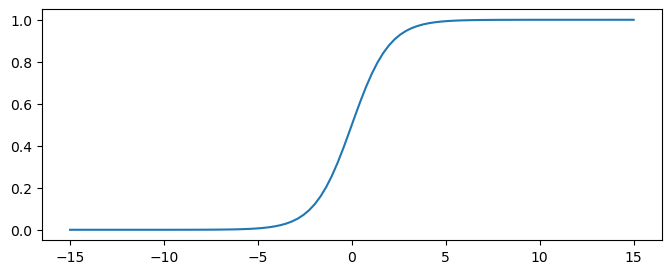

In [7]:
x = np.linspace(-15, 15, 100)
fig, ax = plt.subplots(figsize = (8, 3))
sns.lineplot(x = x, y = 1/(1 + np.exp(-x)))

#### Hyperbolic Tangent Activation Function

This function is similar in shape to the logistic curve, but it constrains the values to be in the $[-1, 1]$ interval (instead of the $[-1, 1]$ used by the logistic):
$$\tanh(x) = \dfrac{e^{x} + e^{-x}}{e^{x} - e^{-x}}$$

<Axes: >

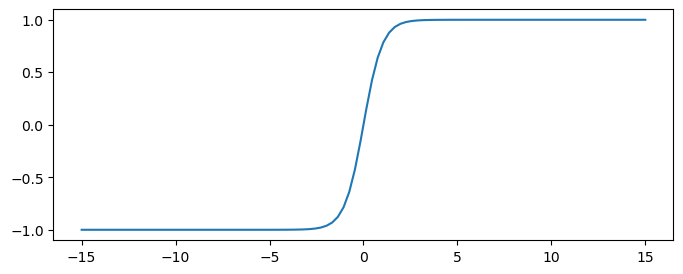

In [8]:
fig, ax = plt.subplots(figsize = (8, 3))
sns.lineplot(x = x, y = np.tanh(x))

#### RELU (Rectified Linear) Activation Function

Probnly the most popular activation function nowadays, the RELU functions is defined as:
$$
RELU(x) =
\begin{cases}
x &\text{ if }x \geq 0\\[3mm]
0 &\text{ if }x < 0\\
\end{cases}
$$
which means that the plot is:


2025-03-05 14:38:14.454173: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-05 14:38:14.454321: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-05 14:38:14.454328: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1741181894.454559  329050 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741181894.454920  329050 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Axes: >

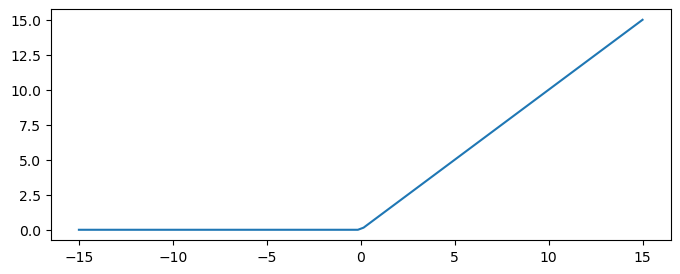

In [ ]:
# def relu(x):
# 	return np.array([max(0, u) for u in x])

# fig, ax = plt.subplots(figsize = (8, 3))
# sns.lineplot(x = x, y = tf.nn.relu(x))

As you can see this function is not linear, but **piecewise linear**. However, this very basic kind of non linearity is enough to prevent the network collapse. And on the other hand the computation of the RELU value is a simple `if` statement, whereas the previous activation functions are computationally much more expensive. This is one of the reasons why RELU has become so popular in recent years. 


---

::: {.callout-note  icon=false}

## The AI Winters and the 2020s AI Spring 

Some theoretical misunderstandings related to the network collapse phenomenon combined with the limitations of the hardware led to what was called the [*first AI winter*](https://en.wikipedia.org/wiki/AI_winter) and research stalled for a long time. Another factor contributing to that decrease of interest in AI was of an algorithmic nature. Some pioneering researchers already knew that multilayer models and non linear activations would solve the issue. But at the time it was not known *how to train a multilayer model*. A new fundamental algorithm, called **backpropagation** was needed for that.

In the meantime, a second era of AI methods appeared in the form of so called *expert systems* in the 1980s. They relied on a completely different methodology: *rule-based systems*. Those are built on a set of explicit rules or if-then statements that try to encode the knowledge and expertise of human experts. In particular they did not use neural networks. But they turned out to be too hard to maintain, and the expectations, hype and investments soon vanished. The second AI winter and the bursting of the dot-com bubble (driven by speculative investment in internet-related companies during the late 1990s) occurred around the same time period. Thus, for a long time, the AI name vanished from the research vocabulary. But the neural networks researchers had kept working and in 1986 the [**backpropagation algorithm**](https://en.wikipedia.org/wiki/Backpropagation#Early_successes) became popular due to a paper in Nature. It had some success, but it was not until the 2010s, when comparatively cheap yet powerful GPUs  became available, that backprop (as it is usually called) found the adequate hardware to unleash its parallel computing capabilities. This has lead to what is sometimes called the current *AI spring* in the 2020s, and the popularization of some AI products such as LLMs. You can get a privileged perspective on that period by watching this [interview with Geoffrey Hinton](https://www.youtube.com/watch?v=-eyhCTvrEtE) by Andrew Ng from deeplearning.ai.

But keep the past in mind, for some already think (hope?) that we are doomed for a new AI winter. This weekend a column in a major newspaper in Spain [Inteligencia Artifical: Nnada que hacer, J. Sampedro, EL PAÍS 2024-04-20.](https://elpais.com/opinion/2024-04-20/inteligencia-artificial-nada-que-hacer.html), after expressing concerns about the potential job losses that AI could cause,  ended with this paragraph:

*"But let's end with some good news. ChatGPT and other systems of this kind are not going to grow exponentially. These models have been improving so far by devouring texts from the internet (more texts, better results), but they have already swallowed almost everything. Stagnation is approaching."*

The text of the article is in Spanish. Ironically, the above English translation was obtained using ChatGPT. 

:::

---

::: {.callout-note  icon=false}

## The Output Layer.

The output layer of a neural network behaves differently depending on the nature of the problem. 

+ **Regression:** If we are dealing with a regression problem then the output layer has a single neuron. This neuron will take as inputs the values coming from the last hidden layer, let us call them 
  $$A_1,\ldots, A_k$$
  and then the output layer will use its set of weights $w_1, \ldots, w_k$ and bias term to output the affine combination:
  $$w_0 + w_1 A_1 +\cdots + w_k A_k$$ 
  This is the final prediction of the model. You may wonder about the activation function for this output layer, but the above is equivalent to using the identity $h(x) = x$ as activation, as we mentioned before.  
+ **Binary Classification:** In this case we want to use the output as a score for the positive class of the output variable. In particular we only need the neural network to predict a aingle number. Therefore in this case again the output layer contains a single neuron. The only difference with the previous regression case is that now the activation function is not the identity but the sigmoid curve we have introduced above:
$$\sigma(x) = \dfrac{1}{1 + e^{-x}}$$
+ **Multiclass Classification and Softmax Function:** This is a different scenario, because of the output variable is a factor with $p$ levels, then the network needs to predict scores for each of them. And so in this case the output layer contains $p$ neurons. The outputs $u_1, u_2, \ldots, u_p$ of these neurons are then typically converted into a new set of numbers $p_1, p_2,\ldots, p_k$ by using a **softmax transformation** defined by:
  $$p_1 = \dfrac{e^{u_1}}{e^{u_1} + e^{u_2} + \cdots + e^{u_p}},\quad 
  p_2 = \dfrac{e^{u_2}}{e^{u_1} + e^{u_2} + \cdots + e^{u_p}},\quad
  \ldots \quad
  , \quad p_k = \dfrac{e^{u_k}}{e^{u_1} + e^{u_2} + \cdots + e^{u_p}}
  $$
  This transformation clearly implies that the numbers $p_i$ verify 
  $$0\leq p1, p_2, \ldots, p_k\leq 1\qquad\text{and}\qquad p_1 + p_2 + \cdots + p_k = 1$$
  and so they are easy to interpret as (usually uncalibrated) probabilities for the $k$ output factor classes.


:::

---

# Multilayer Perceptron Examples in scikit-learn

::: {.callout-note  icon=false}

## A Simple Example for a Binary Classification Problem

Now that we have an initial idea of the architecture of the MLP, we will begin by using sklearn to train a neural network (a MLP in this example) for a binary classification example that we have already used in previous sessions. Keep in mind that sklearn provides implementations only for the most classical and basic ANN architectures, which are precisely the MLPs. For more sophisticated architectures (and to get the most of the hardware) we need to move our work to deep learning libraries such as [Tensorflow/Keras](https://www.tensorflow.org/?hl=es) or [PyTorch](https://pytorch.org). 

:::

Let us begin by recreating the example dataset. To make things more interesting we select an example where a linear boundary is clearly not sufficient. 

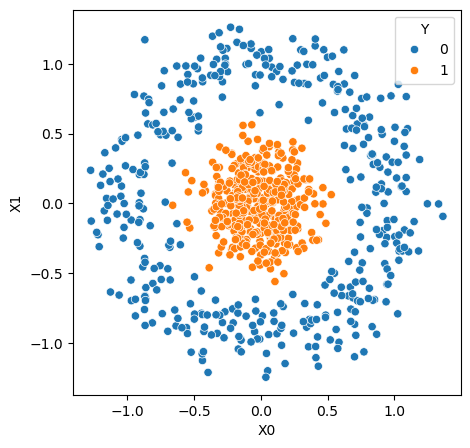

In [10]:
X, Y = make_circles(n_samples=1000, factor=.2, noise=0.15, random_state=2024)

inputs = ["X" + str(k) for k in range(X.shape[1])]
output = "Y"

XTR, XTS, YTR, YTS = train_test_split(X, Y,
                                      test_size=0.2,  # percentage preserved as test data
                                      random_state=1, # seed for replication
                                      stratify = Y)   # Preserves distribution of y

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

fig, ax = plt.subplots(figsize = (5, 5))
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output, ax=ax)
plt.show()


We are going to use these datasets below, so we will make a backup copy to disk (in Python's pickle format).

In [11]:
make_circles_data = {'XTR':XTR, 'XTS':XTS, 'YTR':YTR, 'YTS':YTS, 
    'inputs':inputs, 'output':output}
with open('make_circles_data.pkl', 'wb') as file:
    pickle.dump(make_circles_data, file)

Next we use the [`MLPClassifier` class in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to train a MLP. To define the model we need to describe the architecture of the neural network. In the case of MLPs, this amounts to defining the number of hidden layers and the number of neurons they contain. For this example we are going to use two hidden layers, and we describe them by using a tuple with the number of neurons in each layer. 

Then we also need to select the activation function used by those hidden layers. The MLP implementation in sklearn only allows for chosing a fixed type of activation, that will be applied toall hidden layers. The activation for the output layer is then automatically selected depending on the output variable (a sigmoid for this binary classification problem).  

Another important parameter is the number of fitting iterations. We have not discussed yet how we fit the neural network, but it should come as no surprise that this is an iterative process. If the default number of iterations is not enough to deliver convergence, we try to increase it.

In [12]:
# Create and train the MLPClassifier
mlp_binary = MLPClassifier(hidden_layer_sizes=(8, 6), activation="relu", max_iter=2000, random_state=2024)
mlp_binary.fit(XTR, YTR)

model = mlp_binary
model_name = "mlp_binary"

Let us also save the model as a pickle object.

In [13]:
make_circles_model = {'mlp_binary':mlp_binary}

with open('make_circles_model.pkl', 'wb') as file:
    pickle.dump(make_circles_model, file)

The fitted model object contains information about the MLP weights and bias terms in the `coefs_` and `intercepts_` properties. The `coefs_` is a list of arrays, describing the weights that connect each layer to the preceding one. We can inspect their shapes with

In [14]:
[lyr.shape for lyr in model.coefs_]

[(2, 8), (8, 6), (6, 1)]

The first describes the 16 weights connecting the two inputs (point coordinates) to each of the eight neurons of the first hidden layer. Then the 64 weights connecting the two hidden layers are contained in 

In [15]:
model.coefs_[1]

array([[-4.51589347e-09,  3.09568370e-01,  3.93462057e-01,
         1.07580913e-01, -5.35855889e-17, -7.52727725e-17],
       [-3.08069968e-09,  3.68667143e-08, -1.89023491e-07,
         4.14136197e-25,  7.98146481e-05, -2.12334178e-09],
       [ 2.91508030e-01,  7.22150132e-01, -4.92246382e-01,
        -1.49730891e+00,  3.59313307e-25,  1.43021995e-01],
       [ 4.18481158e-02,  1.59917234e+00, -6.17295775e-01,
        -1.66874272e+00,  3.20263930e-43,  9.57651428e-01],
       [-3.90482357e-01, -1.17389485e+00,  1.03347948e+00,
         1.83352135e+00, -3.24363017e-39,  1.98997800e+00],
       [-3.41442364e-01, -2.07466443e+00,  2.49090921e+00,
         1.93033548e+00, -1.31789459e-05,  1.90175454e+00],
       [-2.58749913e-01,  5.70928544e-01,  8.56381933e-01,
         1.51077681e+00,  2.58794997e-11, -1.61048936e+00],
       [ 6.59127482e-31,  3.13993781e-10,  1.25264721e-05,
        -9.74042812e-02, -2.30775935e-42,  2.24534395e-05]])

And finally there are six weights connecting the neurons of the second hidden layer to the single neuron in the outout layer (for this binary classification problem). 

::: {.callout-tip  icon=false}

### Exercise 002

+ Inspect the `intercepts_` and make sure that you understand their meaning.
+ This should be very easy now: how many parameters (weights and bias terms) does the network in this model contain?

:::

---

::: {.callout-note  icon=false}

## Visualizing the MLP

Execute the next cell to run the external script containing the `mlp_draw` function. We provide this function (that uses the [networkx](https://networkx.org/documentation/stable/index.html) library) to make it easier to visualize small MLP models trained with sklearn.

:::

In [16]:
%run -i mlp_draw.py

Now we only need to feed the fitted model to function. The `orientation`,`figsize`, `label_pos` and `label_size` allow some customization of the result.  Check the architecture of the network in the plot, and see if you can recognize some of the weights that we saw before. 

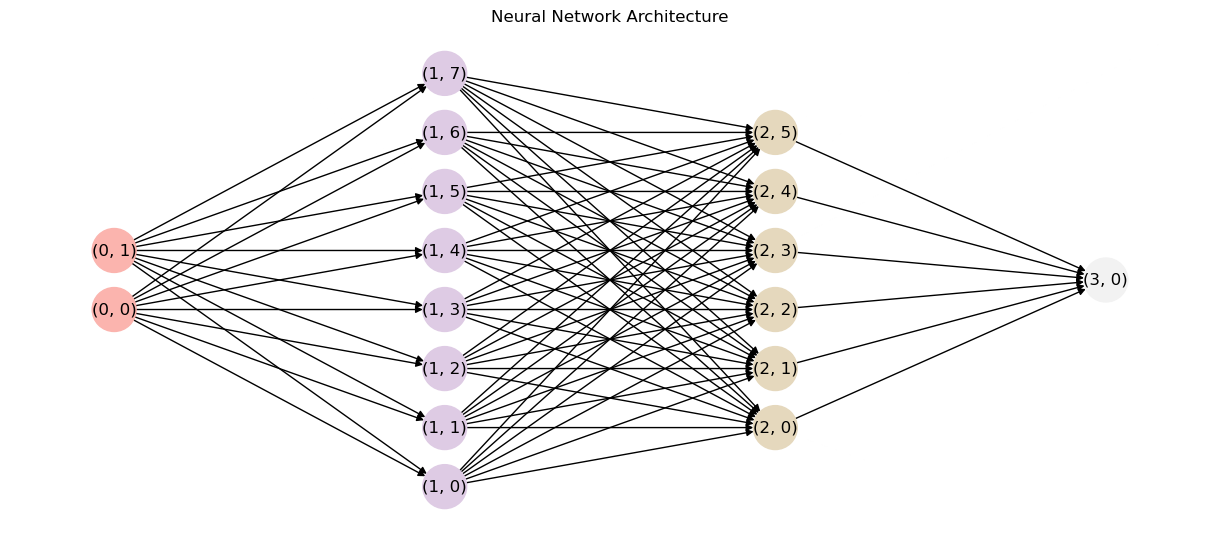

In [17]:
mlp_draw(model=model, orientation="h", label_pos=2.3/7, add_labels=False)

Another interesting visualization is the decision boundary of this binary classifier that clearly shows that it has learned a nonlinear solution. 

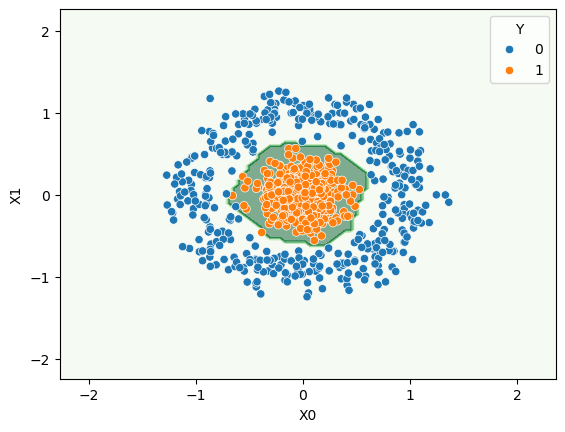

In [18]:
disp = DecisionBoundaryDisplay.from_estimator(model, XTR, response_method="predict", cmap="Greens", alpha = 0.5)
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output)
plt.show()

::: {.callout-tip  icon=false}

### Exercise 003

Change the activation function to `identity` instead of `relu` (read the sklearn documentation to understand what we are doing). Then refit the MLP and repeat the boundary decision plot. What happens?

:::

Let us now evaluate the classifier performance, using our standard toolset:

In [19]:
# Dataset for Training Predictions
dfTR_eval = dfTR.copy()
# Store the actual predictions
newCol = 'Y_'+ model_name +'_prob_neg'; 
dfTR_eval[newCol] = model.predict_proba(XTR)[:, 0]
newCol = 'Y_'+ model_name +'_prob_pos'; 
dfTR_eval[newCol] = model.predict_proba(XTR)[:, 1]
newCol = 'Y_'+ model_name +'_pred'; 
dfTR_eval[newCol] = model.predict(XTR)

In [20]:
# Test predictions dataset
dfTS_eval = dfTS.copy()
newCol = 'Y_'+ model_name +'_prob_neg'; 
dfTS_eval[newCol] = model.predict_proba(XTS)[:, 0]
newCol = 'Y_'+ model_name +'_prob_pos'; 
dfTS_eval[newCol] = model.predict_proba(XTS)[:, 1]
newCol = 'Y_'+ model_name +'_pred'; 
dfTS_eval[newCol] = model.predict(XTS)

This generates the confusion matrices and shows that classification is almost perfect both in training and test.

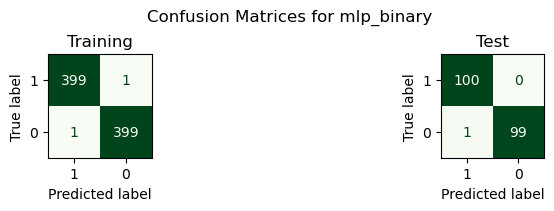

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training'); ax1.grid(False)
ax2 = fig.add_subplot(spec[0, 2]);ax2.set_title('Test'); ax2.grid(False)
ConfusionMatrixDisplay.from_estimator(model, XTR, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0])
ConfusionMatrixDisplay.from_estimator(model, XTS, YTS, cmap="Greens", colorbar=False, ax=ax2, labels=[1, 0])
plt.suptitle("Confusion Matrices for "+ model_name)
plt.show(); 

The ROC curves tell a similar story. We satisfy ourselves that this looks good enough, and will not spend more time on performance measures. Feel free to dig deeper, you have all the tools from previous sessions. 

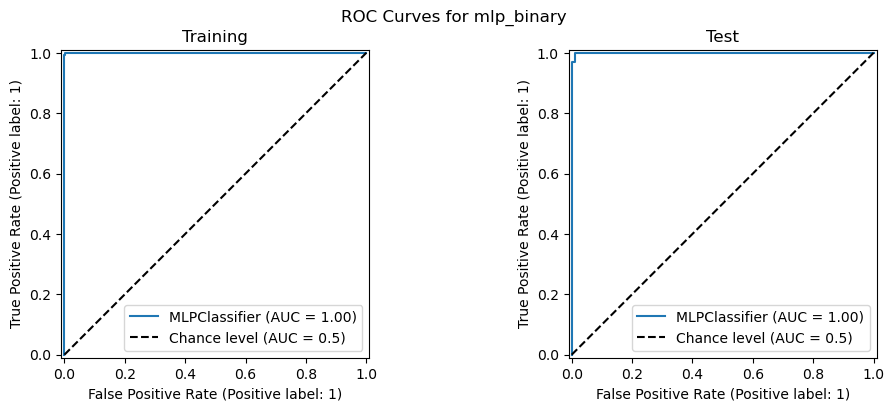

In [22]:
from sklearn.metrics import RocCurveDisplay
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training')
ax2 = fig.add_subplot(spec[0, 1]);ax2.set_title('Test')
RocCurveDisplay.from_estimator(model, XTR, YTR, plot_chance_level=True, ax=ax1)
RocCurveDisplay.from_estimator(model, XTS, YTS, plot_chance_level=True, ax=ax2);
plt.suptitle("ROC Curves for "+ model_name)
plt.show(); 

---

::: {.callout-note  icon=false}

## A Multiclass Example

To illustrate this case we will train a MLP that uses the architecture in Figure 13-11 of [@glassnerVisual2021] that we have seen before (reproduced below for convenience). 

:::

![](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/13-11.png?raw=true){width=45% fig-align="center"}

This MLP architecture can be used to classify the samples in the classical `iris` dataset. To see why recall that this dataset uses as inputs four morphological  characteristics of the iris flowers, while the output factor `Species` has three levels. 

In [23]:
iris = datasets.load_iris()
X = iris["data"]
X_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
df = pd.DataFrame(X, columns=X_names)
Y = "species"
df[Y] = iris["target"] 
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Therefore, it requires a MLP model with four inputs and three output neurons. Let us create the train test split and the datasets and variables that we will use.
**Note that we are scaling the input data.**

In [24]:
inputs = X_names
output = Y

XTR, XTS, YTR, YTS = train_test_split(df[inputs], df[Y],
                                      test_size=0.2,  # percentage preserved as test data
                                      random_state=1, # seed for replication
                                      stratify = df[Y])   # Preserves distribution of y

iris_scaler = StandardScaler()
XTR = iris_scaler.fit_transform(XTR)
XTS = iris_scaler.transform(XTS)

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

Now we can define the model's architecture and train it. Note that we only care about the number and size of the hidden layers. The classifier will look at the number of levels of the output and use the appropriate size and softmax function for the output layer. 

In [25]:
mlp_multi = MLPClassifier(hidden_layer_sizes=(3, 2), activation="relu", max_iter=6000, random_state=2024)
mlp_multi.fit(XTR, YTR)

model = mlp_multi
model_name = "mlp_multi"

Let us save the data and model to disk.

In [26]:
iris_data = {'XTR':XTR, 'XTS':XTS, 'YTR':YTR, 'YTS':YTS, 
    'inputs':inputs, 'output':output, 'iris_scaler':iris_scaler}
with open('iris_data.pkl', 'wb') as file:
    pickle.dump(iris_data, file)

iris_model = {'mlp_multi':mlp_multi}
with open('iris_model.pkl', 'wb') as file:
    pickle.dump(iris_model, file)

After the fit we can confirm the expected structure of the weights for this architecture:

In [27]:
[lyr.shape for lyr in model.coefs_]

[(4, 3), (3, 2), (2, 3)]

Now let us use the `mlp_draw` function to visualize the fitted network and weights (recall, bias terms are omitted).

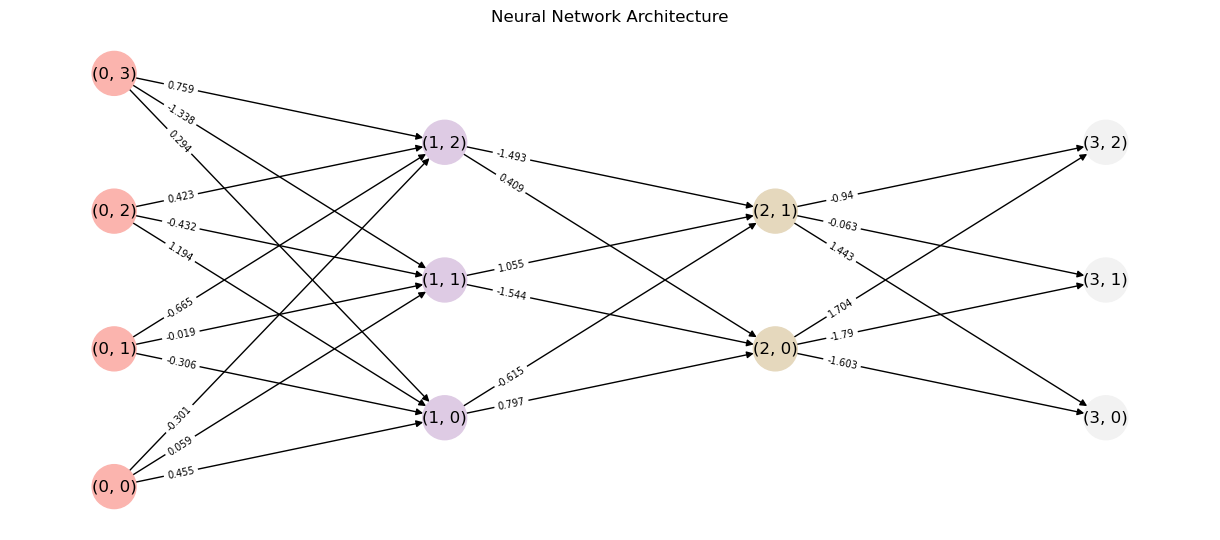

In [28]:
mlp_draw(model=model, orientation="h", label_pos=1.3/7)

The score predictions of this MLP, as expected, appear as tuples of three values, the scores for each of the three iris species corresponding to the data point being classified. For example, the first flower in the test set gets these scores. The class is assigned using the highest score. 

In [29]:
np.round(model.predict_proba(XTS)[0, :], 3)

array([0.   , 0.001, 0.999])

In [30]:
predicted_class = model.predict(XTS)[0]
iris["target_names"][predicted_class] 

'virginica'

And in fact you can see that this very simple MLP model achieves almost perfect prediction on the test set.

In [31]:
pd.crosstab(model.predict(XTS), YTS)

species,0,1,2
row_0,,,
0,10,0,0
1,0,10,1
2,0,0,9


The main goal of this example is to illustrate that there is not much of a difference between binary and multiclass MLP models, so we move on to another Machine Learning task.

---

::: {.callout-note  icon=false}

## A Regression Example

We will create a synthetic dataset for a simple regression problem with just one numeric input, but whith a clearly non linear relation with the output. 

:::

<Axes: xlabel='X', ylabel='Y'>

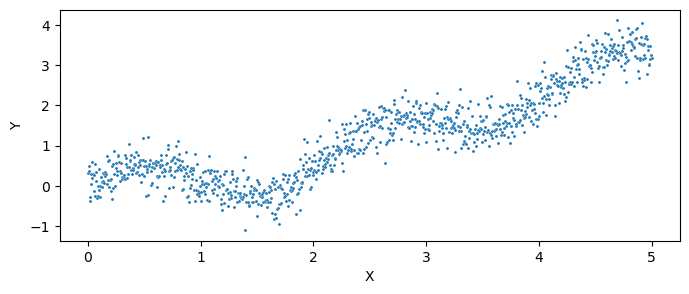

In [32]:
rng = np.random.default_rng(2024)
n = 1000

X = np.linspace(start=0, stop=5, num = n)
Y = X/2 + np.sin(X) * np.cos(2 * X) + 0.3 * rng.normal(size = n)

df = pd.DataFrame({"X":X, "Y":Y})

fig, ax = plt.subplots(figsize= (8, 3))
# sns.lineplot(x = X, y = Y, ax=ax)
sns.scatterplot(data = df, x = "X", y = "Y", ax=ax, s=5)

Next we define the datasets and variables we are going to use:

In [33]:
inputs = ["X"]
output = "Y"

XTR, XTS, YTR, YTS = train_test_split(df[inputs], df[output],
                                      test_size=0.2,  # percentage preserved as test data
                                      random_state=1)
dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS


And we create a MLP model with two hidden layers. We are using a higher number of neurons here and we have switched to [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor). But note that again we do not need to describe the output layer in any way, sklearn uses the approprate values for a regression problem.  Note also that we are **scaling the inputs** to get a better behavior in model fit. And in order to do that we use the pipeline framework we know. 

In [34]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(80, 20), activation="relu", random_state=2024, max_iter=2000)

reg_scaler = StandardScaler()
reg_scaler.set_output(transform="pandas")

mlp_reg_pipe = Pipeline(steps=[('scaler', reg_scaler), 
                           ('mlp', mlp_reg)]) 

mlp_reg_pipe.fit(XTR, YTR)

model = mlp_reg_pipe
model_name = "mlp_reg"


Let us save the data and model to disk (in Python's pickle format).

In [35]:
mlp_reg_data = {'XTR':XTR, 'XTS':XTS, 'YTR':YTR, 'YTS':YTS, 
    'inputs':inputs, 'output':output, 'reg_scaler':reg_scaler}
with open('mlp_reg_data.pkl', 'wb') as file:
    pickle.dump(mlp_reg_data, file)
mlp_reg_model = {'mlp_reg':mlp_reg_pipe}
with open('mlp_reg_model.pkl', 'wb') as file:
    pickle.dump(mlp_reg_model, file)

Let us know look at the model predictions. To visualize the result and get a qualitative measure of the model fit we plot the fitted values against the original data. 

In [36]:
# Dataset for Training Predictions
dfTR_eval = dfTR.copy()
# Store the actual predictions
newCol = 'Y_'+ model_name +'_pred'; 
dfTR_eval[newCol] = model.predict(XTR)

<Axes: xlabel='X', ylabel='Y'>

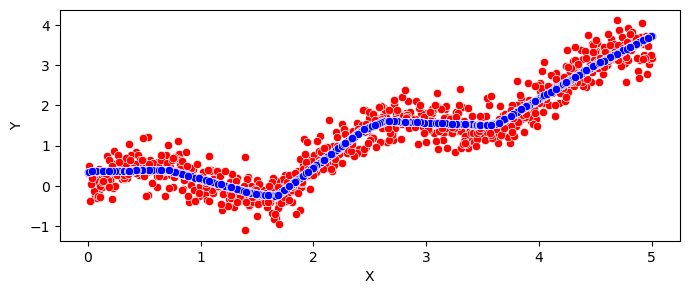

In [37]:
fig, ax = plt.subplots(figsize= (8, 3))
sns.scatterplot(data=dfTR_eval, x = "X", y = "Y", color="r", ax=ax)
sns.scatterplot(data=dfTR_eval, x = "X", y = newCol, color="b", ax=ax)

The same kind of plot for the test set illustrates that the model is indeed learning this non linear signal.

<Axes: xlabel='X', ylabel='Y'>

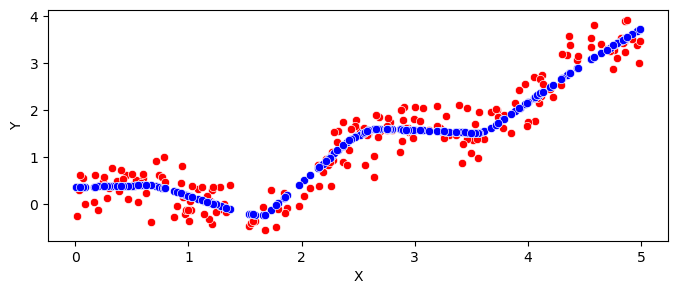

In [38]:
# Dataset for Training Predictions
dfTS_eval = dfTS.copy()
# Store the actual predictions
newCol = 'Y_'+ model_name +'_pred'; 
dfTS_eval[newCol] = model.predict(XTS)
fig, ax = plt.subplots(figsize= (8, 3))
sns.scatterplot(data=dfTS_eval, x = "X", y = "Y", color="r", ax=ax)
sns.scatterplot(data=dfTS_eval, x = "X", y = newCol, color="b", ax=ax)

A plot of the network architecture to illustrate the limitations of this visualization approach. 

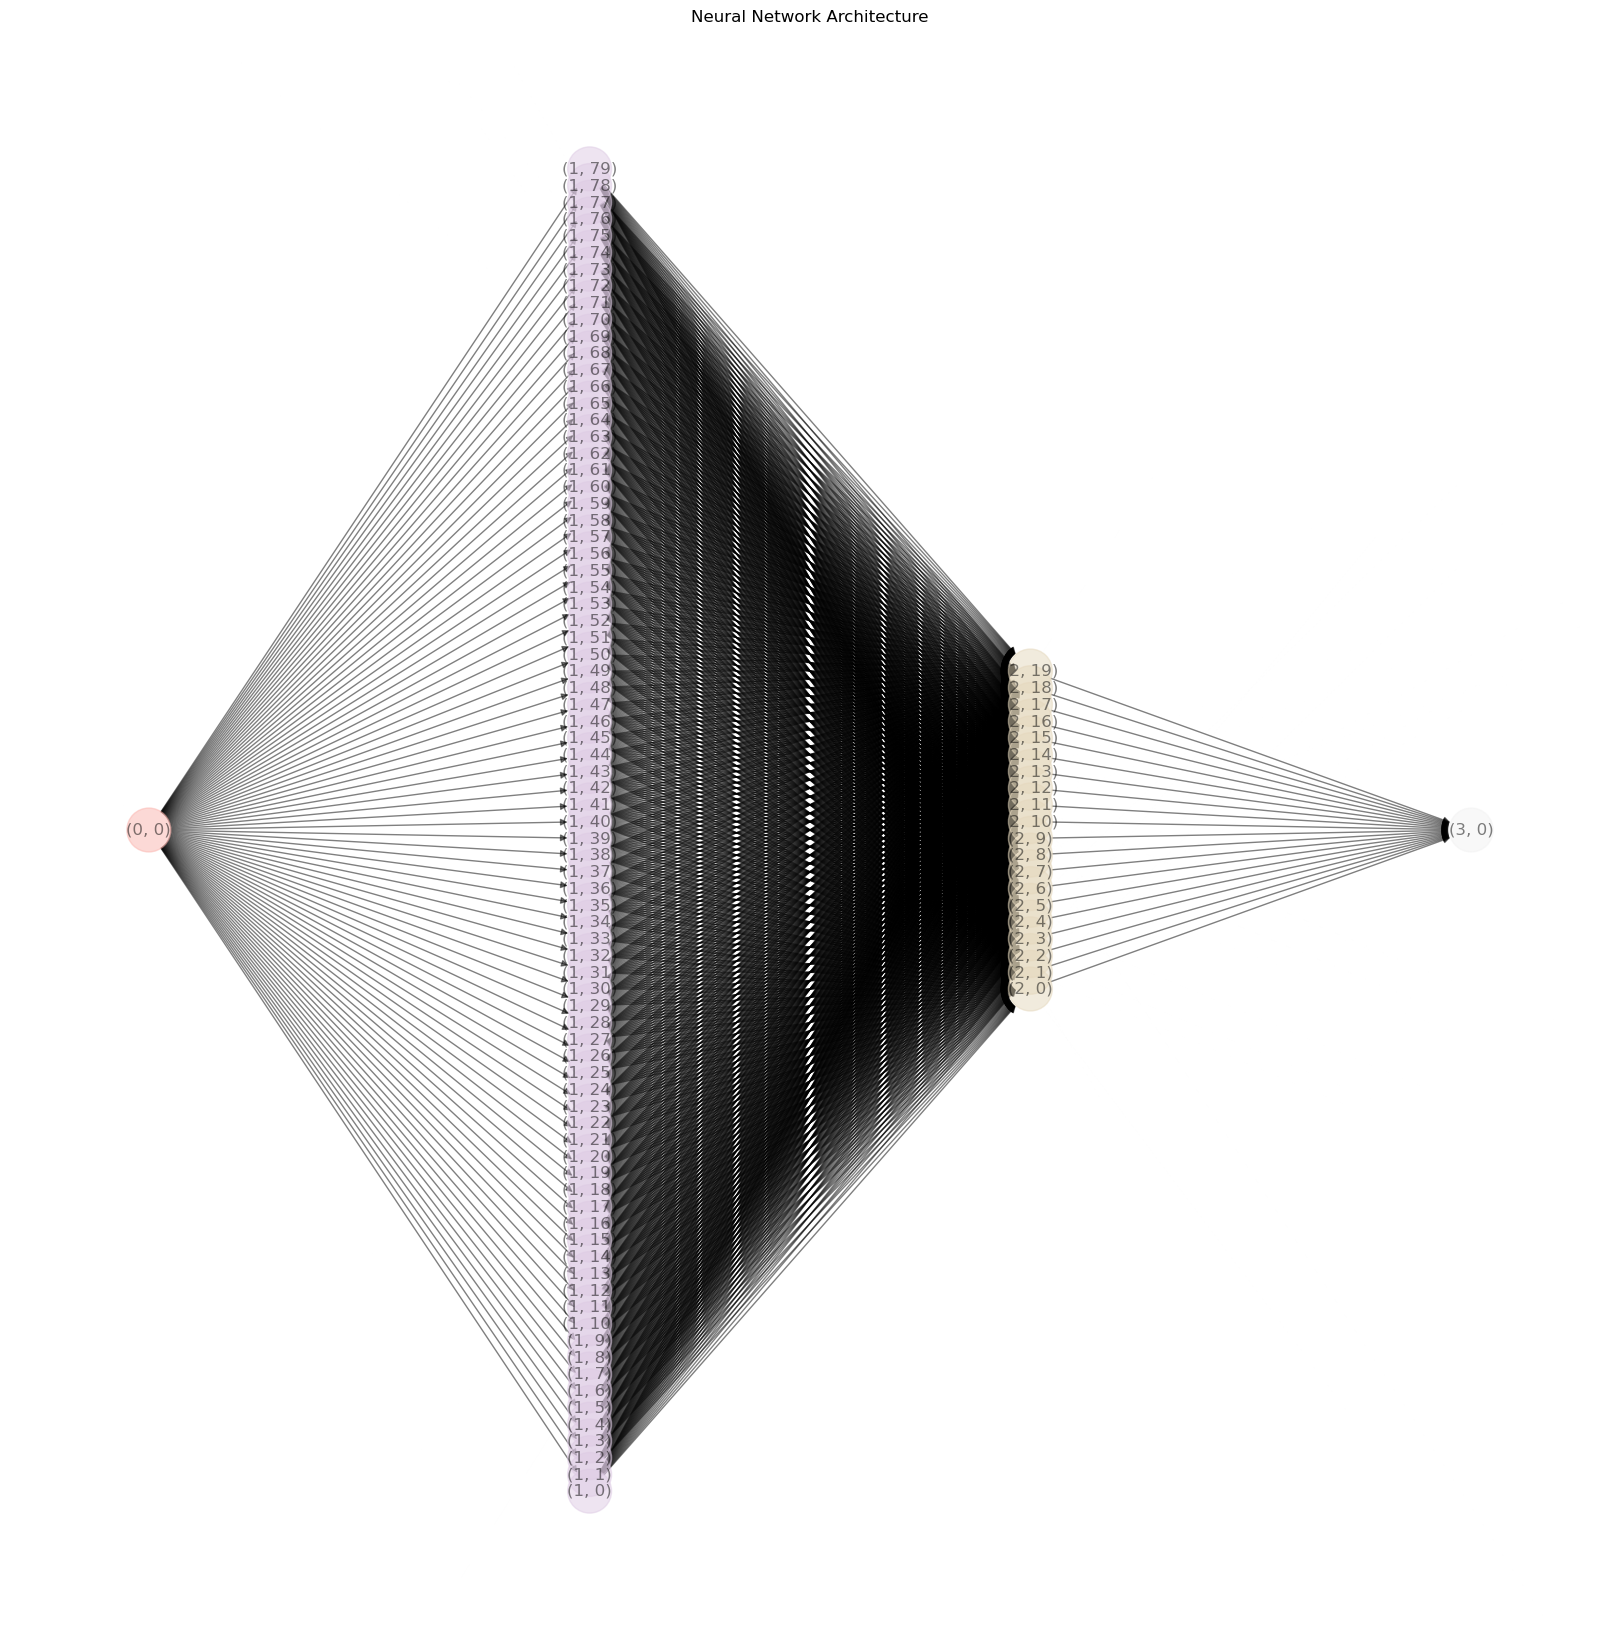

In [39]:
mlp_draw(model["mlp"],  orientation="h", figsize=(16, 16), alpha=0.5, add_labels=False)

But remember that you can always explore the weights and bias terms through the model.

::: {.callout-tip  icon=false}

### Exercise 004

How many parameters are there in this, our largest MLP so far?

:::

---

# Training MLPs through Gradient Descent and Backpropagation

::: {.callout-note  icon=false}

## A Summary of MLP Trainng

How is a MLP model trained? An admittedly short description of the process follows. The rest of this section is devoted to provide details about each of these steps (not necessarily in the order they appear below):

+ We choose a **loss function**, that measures the error in the model's fit to the traing data. Our ideal training goal is to bring the loss as close to zero as possible, while at the same time keeping overfitting under control.
+ We choose **initial values for the weights and bias** terms of the model. Spoiler: random choosing is not a good idea!
+ This and the next step are performed iteratively until some stopping criterion is met. We use the training data or fractions of it called **batches** to get a prediction of the model and therefore we get an evaluation of the loss function for the current choice of the model parameters. This step is called the **forward pass** because the information in the network flows forward (following the arrows). 
+ Next we use the values collected in the forward pass and the **backpropagation algorithm** to compute the gradient of the loss function with respect the parameters in each one of the network layers. With this gradient and some **optimization method** like **gradient descent** and its relatives we uodate all the weights and bias of the model.


:::

---

::: {.callout-note  icon=false}

## Loss Functions

The loss function measures the error makes in its predictions. And, as you already know, we use different expressions of the error depending on the nature of the model's predictions. That is, depending on the kind of Supervised Machine Learning problem.

For **regression** the most commonly used loss functions are the ${\cal L}_{MAE}$ and ${\cal L}_{MSE}$, defined as:
$$
{\cal L}_{MAE} = \dfrac{1}{n}\sum_{i = 1}^n|\hat y_i - y_i|,\qquad
{\cal L}_{MSE} = \dfrac{1}{2n}\sum_{i = 1}^n (\hat y_i - y_i)^2
$$
Here $y_i$ is a true/observed value and $\hat y_i$ is the corresponding prediction of the model. 

For **classification** (either binary or multiclass) the most widely used loss function is the **cross-entropy**, defined as:
$${\cal L}_{ent} = -\sum_{i = 1}^n\sum_{j=1}^m y_{ij}\log\hat y_{ij}$$
where $y_{i1}, y_{i2}, \ldots, y_{im}$ is the one hot encoding of the $i-th$ input and $\hat y_{i1}, \hat y_{i2}, \ldots, \hat y_{im}$ the *scores* assigned by the model, for each of the $m$ levels/classes of the output factor. For the binary case this boils down to
$${\cal L}_{ent} = -\sum_{i = 1}^n  (y_j\log\hat y_j + (1 - y_j)\log(1 - \hat y_j))$$

By the way, `MLPRegressor` always uses what we call ${\cal L}_{MSE}$, while `MLPClassifier` always uses the cross-entropy ${\cal L}_{ent}$. In other libraries there is more freedom to choose other loss functions or even define your own, taylored to the problem (e.g. to use different weights for the classes). 

All these loss functions share some properties that are also critical for their use with the optimization algorithms we use while fitting the models:
1. They are differentiable functions with respect to their arguments.
2. They are sums over a set of observations. And therefore they can be *estimated* using any number of observations. 

:::

<h1 style="color:red">REACHED THIS POINT</h1>

Let us emphasize this idea by playing with the code. Take the training data and fitted model of regression example:

In [40]:
YTR = mlp_reg_data["YTR"]
XTR = mlp_reg_data["XTR"]
model = mlp_reg_model["mlp_reg"]

Now let us use this data and model to get the predictions for training, that correspond to what we called $\hat y_i$ above. We show the first ones.

In [41]:
YTR_pred = model.predict(XTR)
YTR_pred[:10]


array([ 0.26670396,  3.69201112,  3.6049855 ,  0.37045803,  1.58530131,
        1.54973299,  0.36139089,  0.0949725 , -0.18409113,  3.38742146])

These `YTR_pred` predictions are the result of the **forward pass of the entire training set** through the network, **using the present weights and bias terms of the model**. And now we can use them to get the value of the loss function (properly speaking, an *estimate* of the value of the loss function):

In [42]:
loss = (1/2) * ((YTR_pred - YTR)**2).mean()
loss

0.049319401195777296

But if we change the size and/or values of the inputs, creating for example a new shorter array:

In [43]:
Xnew = np.random.default_rng(2024).normal(size = 10).reshape(-1, 1)
Xnew

array([[ 1.02885687],
       [ 1.64192004],
       [ 1.14671953],
       [-0.97317952],
       [-1.3928001 ],
       [ 0.06719636],
       [ 0.86135092],
       [ 0.5091868 ],
       [ 1.81028557],
       [ 0.75084347]])

and the associated output values:

In [44]:
Ynew = Xnew/2 + np.sin(Xnew) * np.cos(2 * Xnew) + 0.3 * rng.normal(size = Xnew.shape[0])

Then we can run them through the betwork (forward pass) and get a prediction:

In [45]:
Ynew_pred = model.predict(Xnew)
Ynew_pred[:10]

/Users/fernando/miniconda3/envs/MLMIC25/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([ 0.14799548, -0.2376762 ,  0.05769325,  0.31106307,  0.2932709 ,
        0.35958583,  0.27633267,  0.38818285,  0.04876662,  0.36026116])

Then we can get a new value of the loss:

In [46]:
loss_new = (1/2) * ((Ynew_pred - Ynew)**2).mean()
loss_new

0.09540873679602241

The neural network does not care if this values belong to the training set, or even about how many they are. But we can take a step further to better understand training. Below we see the 20 weights in the (fitted to training data) outer layer:

In [47]:
model["mlp"].coefs_[2]
outer_weights = model["mlp"].coefs_[2]
outer_weights

array([[-5.25548563e-01],
       [-1.82610993e-01],
       [-2.07258451e-02],
       [ 5.01400632e-01],
       [-2.10009181e-01],
       [ 1.33174938e-02],
       [-4.89055375e-01],
       [ 2.01155719e-02],
       [ 2.95700964e-01],
       [-1.40096016e-01],
       [-2.77540400e-01],
       [ 1.99960980e-09],
       [-3.39275348e-07],
       [-3.11143961e-01],
       [ 4.89647944e-01],
       [ 5.74968143e-01],
       [-4.48779105e-01],
       [ 4.07173610e-01],
       [ 1.26540951e-06],
       [-4.77446082e-01]])

Let us modify them, replacing them with arbitrary uniform values:

In [48]:
model["mlp"].coefs_[2] = np.random.default_rng(2024).uniform(low = 0, high = 0.1, size = 20).reshape(-1, 1)
model["mlp"].coefs_[2] 

array([[0.06758313],
       [0.02143232],
       [0.0309452 ],
       [0.07994661],
       [0.09958021],
       [0.01422318],
       [0.00787255],
       [0.01808238],
       [0.03596469],
       [0.01696192],
       [0.05887593],
       [0.06168075],
       [0.01053857],
       [0.05657311],
       [0.00046296],
       [0.04651192],
       [0.09756222],
       [0.07994284],
       [0.05968224],
       [0.03253497]])

Now we have modified the neural network itself. In fact, in this case we have *untrained* it (effectively ruining it). To see this, let us run again the training set through this altered neural network to get the predictions. You can compare them with the predictions of the original fitted and yet untampered network.

In [49]:
YTR_pred = model.predict(XTR)
YTR_pred[:10]


array([0.39286751, 0.56660871, 0.55717158, 0.47475645, 0.3529616 ,
       0.34419725, 0.48586723, 0.39680396, 0.4032007 , 0.53357875])

Accordingly, the loss function value is different **and much worse!**

In [50]:
loss = (1/2) * ((YTR_pred - YTR)**2).mean()
loss

0.9872144488030444

Before we continue let us restore the model to its pristine fitted state:

In [51]:
model["mlp"].coefs_[2] = outer_weights

::: {.callout-important  icon=false}

## The Loss is a Function of the Weights

It is critically important to understand this examples: the loss function depends on the weights and bias terms. And we can try to train the network by modifying those weights and biases to get lower values of loss for the training data. 

Differently: when you look at the previous expressions for the loss you see $y$ and $\hat y$. The $y$ values belong to the dataset and there is nothing *trainable* about them. But the $\hat y$ are the result of the forward pass of the training data through the neural network. And that means that they are computed using all the weights and bias terms (parameters). Weights and biases are the **trainable components** of the network. 

:::

Let us use the models that we have fitted to illustrate the role played by the loss function. For example, this is the graph of the values of the loss function for the iris dataset as the training of the neural network proceeds:

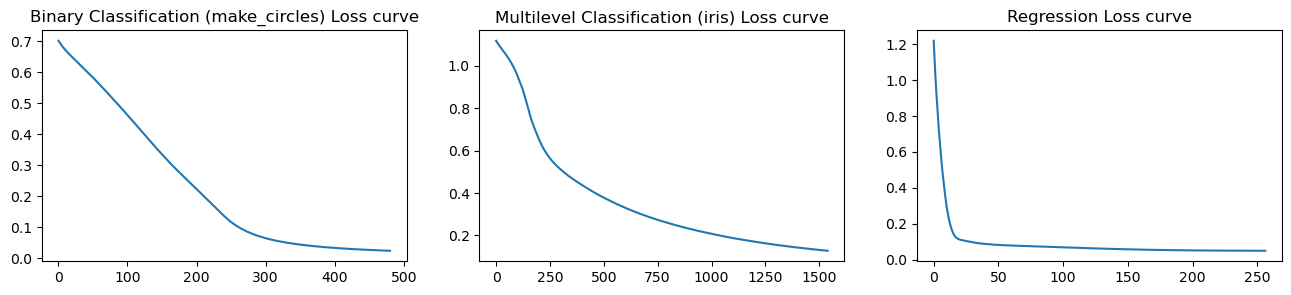

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(1, 3, figsize=(16, 3))
    axs[0].set_title("Binary Classification (make_circles) Loss curve")
    sns.lineplot(make_circles_model['mlp_binary'].loss_curve_, ax=axs[0])
    axs[1].set_title("Multilevel Classification (iris) Loss curve")
    sns.lineplot(iris_model['mlp_multi'].loss_curve_, ax=axs[1])
    axs[2].set_title("Regression Loss curve")
    sns.lineplot(mlp_reg_model['mlp_reg']['mlp'].loss_curve_, ax=axs[2])


The three pictures illustrate that the fitting process proceeds by searching for smaller values of the loss.

---

::: {.callout-note  icon=false}

## Regularization

Keep in mind that our goal when working with loss functions is to get the minimum value, as they are error functions. However, we need to fight overfitting while doing this. A large neural network (in terms of trainable paremeters) is a very flexible model. That is why these loss functions are often combined with regularization techniques similar to the Ridge regression and Lasso that we have seen for linear models. For example the `MLPClassifier` and `MLPRegressor` of sklearn both use an argument `alpha` that controls the regularization using a Ridge-like term added to the loss function.




:::

In [53]:
alphas = [10**k for k in range(-5, 5, 2)]

loss_curves = []
test_scores = []

for i in range(len(alphas)):
    mlp_reg_batch = MLPRegressor(hidden_layer_sizes=(80, 20), alpha=alphas[i],
        activation="relu", random_state=2024, max_iter=2000)

    reg_scaler_batch = StandardScaler()
    reg_scaler_batch.set_output(transform="pandas")

    mlp_reg_batch_pipe = Pipeline(steps=[('scaler', reg_scaler_batch), 
                           ('mlp', mlp_reg_batch)]) 

    mlp_reg_batch_pipe.fit(XTR, YTR)
    
    test_scores.append(mlp_reg_batch_pipe.score(XTS, YTS))

    model_batch = mlp_reg_batch_pipe
    loss_curves.append(model_batch['mlp'].loss_curve_)

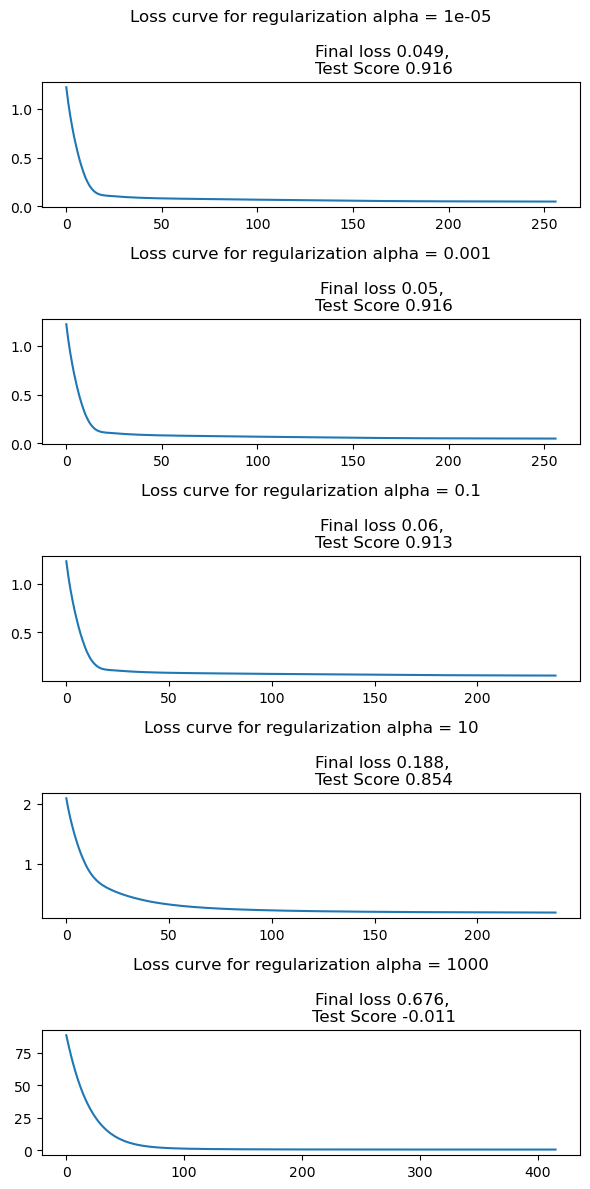

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(len(alphas), 1, figsize=(6, 12))
    for i in range(len(alphas)):
        sns.lineplot(loss_curves[i], ax=axs[i])
        axs[i].set_title(f"""Loss curve for regularization alpha = {alphas[i]}\n 
                            Final loss {np.round(loss_curves[i][-1], 3)}, 
                            Test Score {np.round(test_scores[i], 3)}""")
fig.tight_layout()
    
    

::: {.callout-note  icon=false}

## Dropout

Dropout is another form of regularization in which we randomly disconnect some neurons on one layer when computing the activations. This is similar in spirit to what we did in random forests: restricting the information available for the model helps prevent underfitting and forces the model to focus on the overall signal in the data instead of getting lost in details. 

This dropout methos id only used during training. When making predictions, all neurons in the network and their associated weights are used. Dropout is often implemented as an extra layer placed in between orinary layers, that takes care of this switching off of some neurons. 

:::

---

::: {.callout-note  icon=false}

## Gradient Descent

In a typical first year Calculus students learn that if a function $f$ is differentiable, then the graph of the function is steepest in the direction of the the gradient. Therefore, if you are aiming for smaller values of $f$, eventually reaching a minimum, then a seemingly sensible idea is to move in the opposite direction of the gradient. 

This can be made into an iterative process in discrete steps as follows:
1. If you are located at  point $\bar p$, find the gradient at that point $\nabla f(\bar p)$. We will explain below how to do this using backpropagation, 
2. Take a step of a certain length $\gamma$ in the direction that is opposite to the gradient. That is, your new position is
  $$\bar q = \bar p - \gamma\nabla f(\bar p)$$
3. Repeat the operation at $\bar q$: find $\nabla f(\bar q)$, use it to take a $\gamma$ sized step, and so on. 

The $\gamma$ parameter is called the **learning rate**.

This iterative process is the basic idea of [Gradient descent numerical optimization](https://en.wikipedia.org/wiki/Gradient_descent) algorithms. You can visualize and experiment with the idea using this [construction by Ben Frederiksson](http://www.benfrederickson.com/numerical-optimization/), which also contains visualizations for some other optimization methods. Or you can use our own [GeoGebra visualization](https://www.geogebra.org/m/c9n3vdnr). 

By playing with this visualizations you will discover that the choice of the learning parameter is critical: a too small value and the method may never converge. A too large value and the method may overshoot the minimum, possibly not converging either. There are further difficulties: the initial point of the oterations plays an important part in the success or failure of the method. Besides, if the function has several *local minimum* values the method may converge to one such local minimum and fail to find the *global minimum* value. 

The appeal of gradient descent is obvious, however, and it is based in a very simple yet powerful idea: the only critical skill it requires is the ability to **compute the gradient** of the function wherever you are. And by "wherever you are" we mean a point in the space of parameters (weights and biases) of the network. 

We have seen before how running the training set through the forward pass of the network will give us the value of the loss function. That loss value depends, as we keep repeating, on the current selection of weights and biases for the network. The entire selection of weights and biases is the $\bar p$ in the description of gradient descent. Assume for a moment that we already know how to compute the gradient $\nabla\cal L(\bar p)$. Then we apply the equation in the second step of gradient descent to change each weight and bias in the network. Then we run the training set through the network again, get a new gradient and so on. That is the essence of how we train the network.

:::

---

::: {.callout-note  icon=false}

## Batches and Stochastic Gradient Descent, Epochs.

The above discussion assumes that we use the whole training set in each iteration of gradient descent. But we have also seen that we can use any subset of the input data to get an estimate of the value of the loss function. And we will see that below that we can also use that smaller part of the data to get an estimate of the gradient $\nabla\cal L(\bar p)$. Of course, an estimate based in a smaller data sample is expected to be a lower quality estimate. So, why would we do that? 

First, because selecting a smaller subset speeds up computation. Second, because using a theoretically worse version of the gradient has empirically proved to help the training process. Possibly by escaping local minima that could act like a trap for the gradient descent iterations.

This method of using smaller subsets of the training data is called **stochastic gradient descent** (because each gradient we compute will be a random or stochastic estimate of the gradient for the whole training set). And it is organized as follows:
1. We shuffle (randomly permute) the training data. 
2. We divide the shuffled data into **batches** (or **minibatches**, depending on the authors). They are usually sized as a power of 2 to benefit from the computing architecture of our computers. This implies that there may be a final batch whose size is smaller. For example, with 100 trainig data and 16-sized minibatches you will end up with 6 full sized minibatches and a last one with only 4 elements, since $6\cdot 16 + 4 = 100$. 
3. Each minibatch is used in turn to make a forward pass, compute the loss gradient with backpropagation and uodate the network parameters. The result of this set of operations for all minibatches is called an **epoch** of training. 
4. Then we start a new epoch and repet the above three steps. Training proceeds this way until some stopping criterion is met, concerning the changes on the loss function or a predefined maximal number of epochs.


:::

In scikit-learn we can control this with the `batch_size` argument of both `MLPClassifier` and `MLPRegressor`. 

In [55]:
batch_sizes = [2, 64, 256, XTR.shape[0]]

loss_curves = []

for i in range(len(batch_sizes)):
    mlp_reg_batch = MLPRegressor(hidden_layer_sizes=(80, 20), batch_size= batch_sizes[i],
        activation="relu", random_state=2024, max_iter=2000)

    reg_scaler_batch = StandardScaler()
    reg_scaler_batch.set_output(transform="pandas")

    mlp_reg_batch_pipe = Pipeline(steps=[('scaler', reg_scaler_batch), 
                           ('mlp', mlp_reg_batch)]) 

    mlp_reg_batch_pipe.fit(XTR, YTR)

    model_batch = mlp_reg_batch_pipe
    loss_curves.append(model_batch['mlp'].loss_curve_)

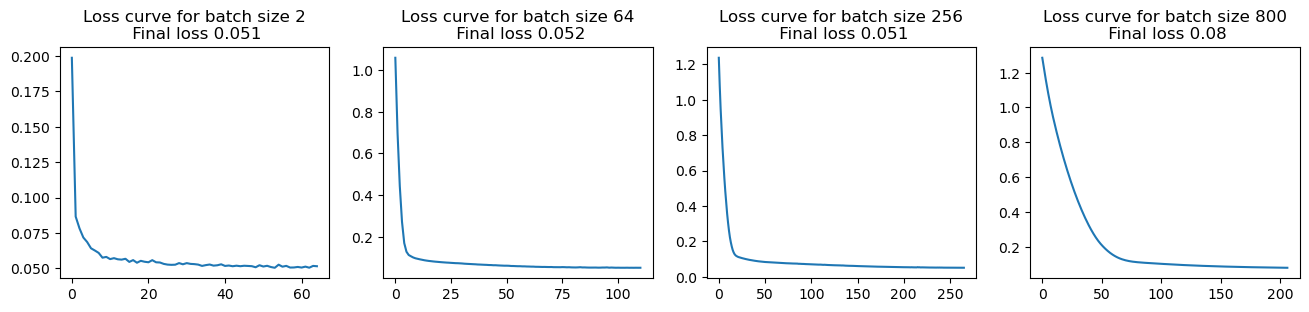

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(1, len(batch_sizes), figsize=(16, 3))
    for i in range(len(batch_sizes)):
        sns.lineplot(loss_curves[i], ax=axs[i])
        axs[i].set_title(f"Loss curve for batch size {batch_sizes[i]}\n Final loss {np.round(loss_curves[i][-1], 3)}")
    
    

The results show that, all other things equal, using the whole training set (last loss curve) is not a good idea. Apparently it fails to reach the minimum. Note also that the first curve is much *noisier*, due to the fact that the estimates of the gradient are much more unstable. 

---

::: {.callout-note  icon=false}

## Choosing the Learning Rate. Momentum.

Choosing the learning rate is often a critical choice when training a neural network. Recall that the learning rate controls the size of the step we take when performing gradient descent. On the one hand, if we take too large a step we risk jumping over the minimums or bouncing endlessly without finding a good fit of the model. If, on the other hand, we choose a step size too small, we risk getting stuck in a plateau of the loss function and not reaching a minimum. 

A relate idea is that of **momentum**. This physically inspired method adds a *gradient memory* to the gradient descen strategy. That means that, to take the next step,  instead of using only the latest value of the gradient we add a fraction of the previous gradient. This has been shown to improve the convergence of the method to better (smaller) loss values.  

Let us use the example of a neural network for regression that we have trained and see the impact of different learning rates.  First we turn off momentum entirely. 

**Technical note:** we have switched to `solver = 'sgd'` so that we can keep a constant value of the learning rate during the whole training process. We will return to this below. 

:::

In [57]:
learning_rates = [0.00001, 0.005, 0.01, 0.05, 0.1, 0.5]

loss_curves = []
train_scores = []

for i in range(len(learning_rates)):
    # print(learning_rates[i])
    mlp_reg_batch = MLPRegressor(hidden_layer_sizes=(80, 20), learning_rate='constant', solver='sgd',
        learning_rate_init=learning_rates[i], momentum = 0, activation="relu", random_state=2024, max_iter=2000)

    reg_scaler_batch = StandardScaler()
    reg_scaler_batch.set_output(transform="pandas")

    mlp_reg_batch_pipe = Pipeline(steps=[('scaler', reg_scaler_batch), 
                           ('mlp', mlp_reg_batch)]) 

    mlp_reg_batch_pipe.fit(XTR, YTR)
    
    train_scores.append(cross_val_score(mlp_reg_batch_pipe, XTR, YTR, scoring='neg_mean_squared_error').mean())

    model_batch = mlp_reg_batch_pipe
    loss_curves.append(model_batch['mlp'].loss_curve_)

/Users/fernando/miniconda3/envs/MLMIC25/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fernando/miniconda3/envs/MLMIC25/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fernando/miniconda3/envs/MLMIC25/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/fernando/miniconda3/envs/MLMIC25/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization has

Now let us see the loss curves and validation scores of the different learning rates. 

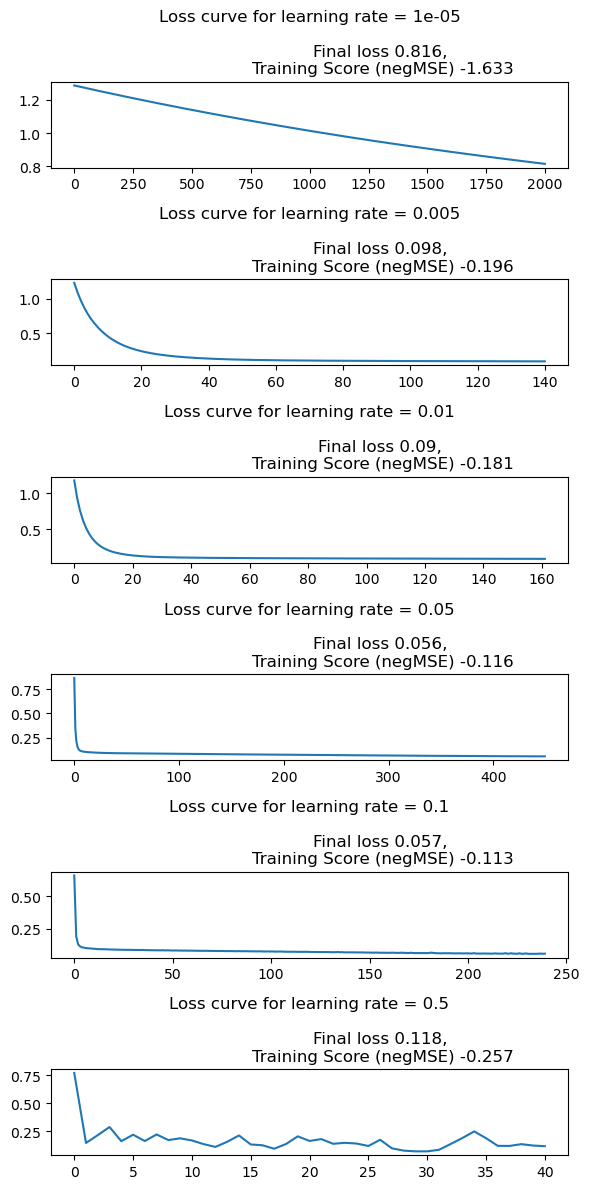

In [58]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(len(learning_rates), 1, figsize=(6, 12))
    for i in range(len(learning_rates)):
        sns.lineplot(loss_curves[i], ax=axs[i])
        axs[i].set_title(f"""Loss curve for learning rate = {learning_rates[i]}\n 
                            Final loss {np.round(loss_curves[i][-1], 3)}, 
                            Training Score (negMSE) {np.round(train_scores[i], 3)}""")
fig.tight_layout()
    
    

The result of the experiment confirms what we said before. The smallest learning rate value gives a very bad result which fails to find any interesting loss value after 2000 iterations. We are simply moving too slow. At the other side of the experiment, the largest learning rate results in a bouncing loss function that does not provide a good fit. Meanwhile, some intermediate values of the learning rate seem to be doing much better. 

Let us now bring back momemntum; it is on by default, so we only need to remove the `momentum=0` option and rerun the code. 

In [59]:
learning_rates = [0.00001, 0.005, 0.01, 0.05, 0.1, 0.5]

loss_curves = []
train_scores = []

for i in range(len(learning_rates)):
    # print(learning_rates[i])
    mlp_reg_batch = MLPRegressor(hidden_layer_sizes=(80, 20), learning_rate='constant', solver='sgd',
        learning_rate_init=learning_rates[i], activation="relu", random_state=2024, max_iter=2000)

    reg_scaler_batch = StandardScaler()
    reg_scaler_batch.set_output(transform="pandas")

    mlp_reg_batch_pipe = Pipeline(steps=[('scaler', reg_scaler_batch), 
                           ('mlp', mlp_reg_batch)]) 

    mlp_reg_batch_pipe.fit(XTR, YTR)
    
    train_scores.append(cross_val_score(mlp_reg_batch_pipe, XTR, YTR, scoring='neg_mean_squared_error').mean())

    model_batch = mlp_reg_batch_pipe
    loss_curves.append(model_batch['mlp'].loss_curve_)

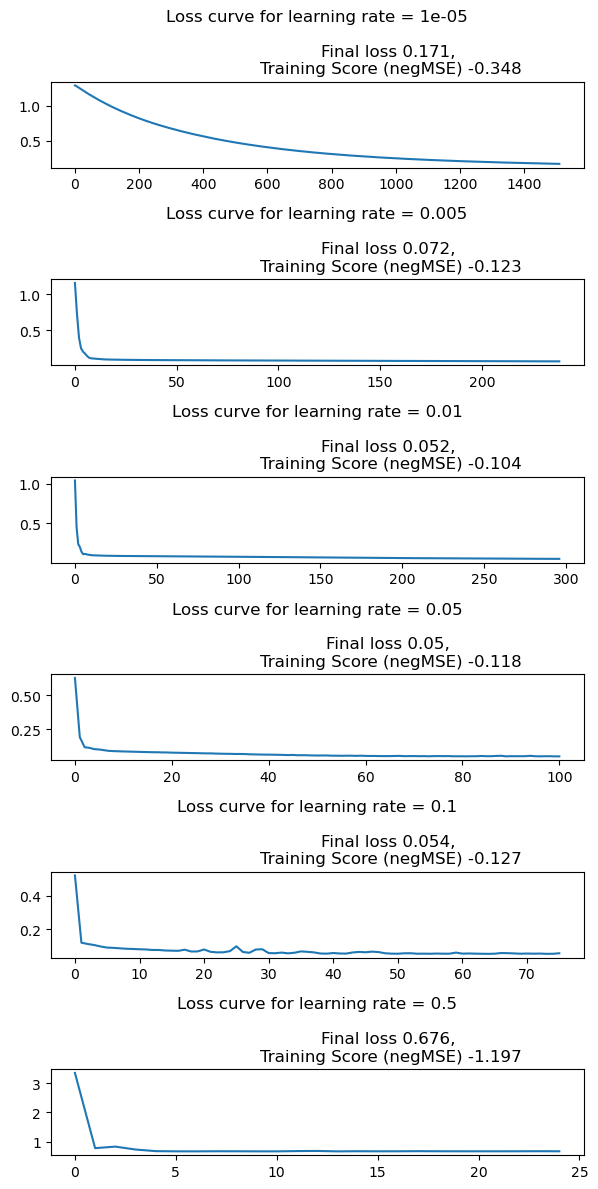

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axs = plt.subplots(len(learning_rates), 1, figsize=(6, 12))
    for i in range(len(learning_rates)):
        sns.lineplot(loss_curves[i], ax=axs[i])
        axs[i].set_title(f"""Loss curve for learning rate = {learning_rates[i]}\n 
                            Final loss {np.round(loss_curves[i][-1], 3)}, 
                            Training Score (negMSE) {np.round(train_scores[i], 3)}""")
fig.tight_layout()
    
    

The impact of momentum is a global improvement of the behavior *across all learning rates*. And the ordering is preserved in this case, the best learning rates are still similar, but the convergence of the method improves and we get better final values of the loss. 

---

::: {.callout-note  icon=false}

## Optimizers

The term optimizers describes a set of tools designed to speed up learning by improving the efficiency of gradient descent (see Chapter 15 of [@glassnerVisual2021]). For example, instead of keeping a constant learning rate, we can use a **learning rate schedule method**. A natural idea is to take longer steps at the beginning, trying to move swiftly across the possible plateaus in the loss function, and then slowing down as we may come closer to a minimum. 

This startegy can be easily accomplished by usinby selecting a smaller than 1 **decay rate** $s$ and then multiplying the learning rate $\lambda$ after each step by this decay rate. That means that instead of a constant learning rates now we are using an exponentially decaying sequence of (decreasing to zero) learning rates:
$$
\lambda, s\,\lambda, s^2\,\lambda,\ldots, s^k\,\lambda,\ldots \rightarrow 0
$$

The idea behind this is illustrated by this Figure 15-16 from [@glassnerVisual2021].

![](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Figures/Images/15-16.png?raw=true){width=60% fig-align="center"}

There are many possible variants vased on this basic idea. We can apply the learning rate update after each epoch,instead of after every gradient descent step. Or we can monitor the loss and change the learing rate using that information (e. g. slowing down if we detetct that *bouncing*). The idea of momentum can be considered as well to be an optimizer. There are indeed improved version of momentum, notably **Nesterov's momentum**: it combines *momentum the past* with anticipated gradient values *from the future* to obtain a corrected update of the gradient that has been shown to perform usually better than simple momentum. In scikit-learn you can use it when you (manually) select stochastig gradient descent.

Another family of optimizer techniques adapt the learning rate to each individual parameter (weights and bias) of the network. The most popular of these **adaptive methods** is called **Adam** (from Adaptive Moment Estimation). You may think of the Adam and related methods as finding a decay rate taylored for each individual parameter, which takes into account the history of changes that  the parameter has undergone, ranking them by how recent they are. The MLP functions of scikit-learn use Adam and by default to implement gradient descent. 

:::

---

::: {.callout-note  icon=false}

## Backpropagation


If gradient descent is the engine of neural networks, backpropagation (*backprop* for short) provides the fuel. That is, the gradient. And it is essentially a clever application of the *chain rule* from Calculus and some dynamic programming ideas to optimize the computation and avoiding repeatedly computing the same quantity.

Here we will focus on the chain rule part of backprop, which is conceptually the cornerstone of the algorithm. To illustrate the idea we consider the neural network in our regression example, pictured below. Recall that the loss function $\cal L$ is a function of the weights and bias terms of the network. And let us suppose that we want to compute the following component of the gradient:
$$\dfrac{\partial \cal L}{\partial w^{(1)}_{04}}$$
where $w^{(1)}_{04}$ is the weight for the green colored edge of the graph.

:::



![](backprop01.png){width=80% fig-align="center"}

To understand the notation consider the picture below. We are closely following here the notation in Chapter 10 of [@ISLP2023]:

![](backprop02.png){width=80% fig-align="center"}

+ The weights in the $r-th$ hidden layer number are called $w^{(r)}_{ij}$. The subscripts $i$ and $j$ indicate the numbers of the neurons they connect. 
+ For the special case of the input layer, $i$ indicates the input number. Thus, the weight $w^{(1)}_{04}$ we are considering connects the input $X_1$ to the fourth neouron in the first hidden layer.  
+ The bias term of the $j-th$ neuron in the $r-th$ hidden layer is indicated by $w^{(r)}_{Bj}$. 
+ The $j-th$ neuron in the $r-th$ layer computes the activation
    $$A^{(r)}_{j} = h^{(r)}(z^{r}_{j}) = h^{(r)}\left(w^{(r)}_{Bj} 
    +\underbrace{w^{(r)}_{0j}A^{(r-1)}_{0j} + w^{(r)}_{1j}A^{(r-1)}_{1j} + \cdots}_{\text{ sum over all neurons of preceding layer}}
    \right)$$ 
  where $h^{(r)}$ is the *common* activation function for the $r-th$ hidden layer (e.g. relu).  
  For the special case of the first hidden layer, the activations $A^{(r-1)}_{kj}$ must be replaced with the $k$-th input value. 
+ For the output layer we use the superscript $(out)$. Thus $h^{(out)}$ is the output layer activation function (usually the identity in regression), 
and $w^{(out)}_{rs}$ indicates a weight in the output layer. In regression there is only a neuron in the ourput layer and so in principle the second subscript could be omitted, but we leave it there for greater generality.


What do the red and blue edges represent? In this regression problem, where the loss is
$${\cal L}_{MSE} = \dfrac{1}{2n}\sum_{i = 1}^n (\hat y_i - y_i)^2$$
the predicted value $\hat y_i$ is computed using the activations in the second hidden layer and the weights $w^{(out)}_{rs}$ of the output layer. These weights are the rightmost group pf colored edges. 

But then we must realize that $\hat y_k$ has been obtained  And each neuron of the second hidden layer is computed from activations coming from the first hidden layer. The second group of red edgex identify how the activation $A^{(1)}_{4}$ (first hidden layer, neuron number 4) is used as input in each of the neurons of the second hidden layer. And we care about neuron number 4 because the (green edge) weight $w^{(1)}_{04}$ is one of the inputs of that neuron (and only that neuron).

To apply the chain rule we need to think of all the composition paths that connect the loss function value to $w^{(1)}_{04}$. Now you can see that this is what the red edges represent. We must compute a product of derivatives along each one of thoose paths and then we add up the results. The blue colored path is a particular example of one such composition paths. Let us follow the chain of derivatives of this blue path in the backward direction of the algorithm.
+ We can begin by computing
$$
\dfrac{\partial \cal L}{\partial \hat y_i} = \dfrac{1}{n}\sum_{i = 1}^n (\hat y_i - y_i)
$$
Recall that $\hat y_i$ is the prediction that the network outputs for input values $(X_i0, X_{i1})$.  
Now 
$$\hat y_i = h^{out}(z_{out}) = h^{out}\left(
w^{out}_{B} + w^{out}_{0}A^{(2)}_0 + w^{out}_{0}A^{(2)}_0 +\cdots + 
\color{blue}w^{out}_{3}A^{(2)}_3\color{black} + \cdots + w^{out}_{5}A^{(2)}_5
\right)$$
and so the next derivative in the blue chain is:
$$\dfrac{\partial \hat y_i}{\partial A^{(2)}_3} = (h^{out})'(z_{out})\cdot w^{out}_{3}$$
Now we have reached $A^{(2)}_3$ with
$$
A^{(2)}_3 = h^{2}(z^{(2)}_3) = h^{(2)}\left(
w^{(2)}_{B3} + w^{(2)}_{03}A^{(1)}_{03} + w^{(2)}_{13}A^{(1)}_{1} +\cdots + 
\color{blue}w^{(2)}_{43}A^{(1)}_4\color{black} + \cdots + w^{(2)}_{73}A^{(1)}_7
\right)
$$
The next derivative in our path is therefore:
$$\dfrac{\partial A^{(2)}_3}{\partial A^{(1)}_4} = (h^{2})'(z^{(2)}_3)\cdot w^{(2)}_{43}$$
Finally (in this really simple neural network) we reach $A^{(1)}_4$ with
$$
A^{(1)}_4 = h^{1}(z^{(1)}_4) = h^{(1)}\left(
w^{(1)}_{B4} + \color{green}w^{(1)}_{04}X_{i0}\color{black} + w^{(1)}_{14}X_{i1}
\right)
$$
The green color highlights that we have reached the desired weight $w^{(1)}_{04}$ and so the final derivatives in the chain are:
$$\dfrac{\partial A^{(1)}_4}{\partial w^{(1)}_{04}} = (h^{1})'(z^{(1)}_4)\cdot X_{i0}$$
Putting all the pieces toghether the product of derivatives along the blue path is:
$$\dfrac{\partial \cal L}{\partial \hat y_i}\cdot(h^{out})'(z_{out})\cdot w^{out}_{3}\cdot 
(h^{2})'(z^{(2)}_3)\cdot w^{(2)}_{43}\cdot  (h^{1})'(z^{(1)}_4)\cdot X_{i0}$$
The derivative 
$$\dfrac{\partial \cal L}{\partial w^{(1)}_{04}}$$
is a sum of six products like this, one for each red or blue path in the picture. Remember that the forward pass has provided us with all the weights 
and all the affine combinations $z^{(i)}_j$. In particular, we know all the values that appear in the above product, and so **we can compute the gradient.** 

The above construction for the gradient may seem intimidating at first, but it should be lcear that we can use matrix computations to organize the chain rule and parallelize it during computation In many cases we find it convenient to think in terms of higher dimensional *stacks of arrays*, so called **tensors**. That is the origin of the name of one of the mfirst and most popular deep learning libraries, [**tensorflow**](https://www.tensorflow.org).

The graph below, from a video at [3Blue1Brown](https://www.3blue1brown.com/topics/neural-networks), conveys the idea of the backpropagation algorithm as a backward flow of tensor information used to update the gradient. 

![](https://miro.medium.com/v2/format:webp/0*Mlm6PXQe4KCc_tku)

---

---

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()
print("Tensorflow version: ", tf.__version__)
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# for device in tf.config.experimental.list_physical_devices():
#     details = tf.config.experimental.get_device_details(device)
#     print(details)
    

Tensorflow version:  2.12.0
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.keras.backend.set_floatx('float32')

# # To run without GPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
# Ensure inputs are in float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [5]:
print("Train Data NaNs:", np.isnan(X_train).sum())
print("Train Labels NaNs:", np.isnan(y_train).sum())
print("Test Data NaNs:", np.isnan(X_test).sum())
print("Test Labels NaNs:", np.isnan(y_test).sum())

print("Max Value in Train Data:", np.max(X_train))
print("Min Value in Train Data:", np.min(X_train))


Train Data NaNs: 0
Train Labels NaNs: 0
Test Data NaNs: 0
Test Labels NaNs: 0
Max Value in Train Data: 255.0
Min Value in Train Data: 0.0


In [6]:
X_train.shape

(55000, 28, 28)

In [7]:
X_train.dtype

dtype('float32')

In [8]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

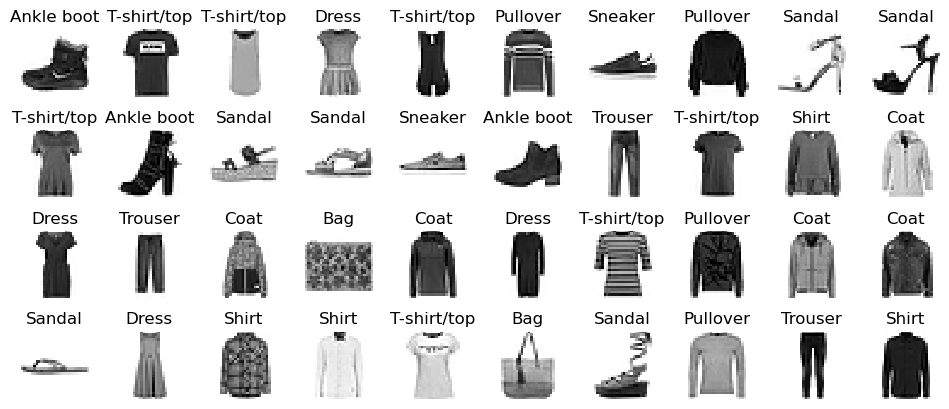

In [10]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [11]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))

# model.add(tf.keras.layers.Dense(300, activation="relu"))
# model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))



Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


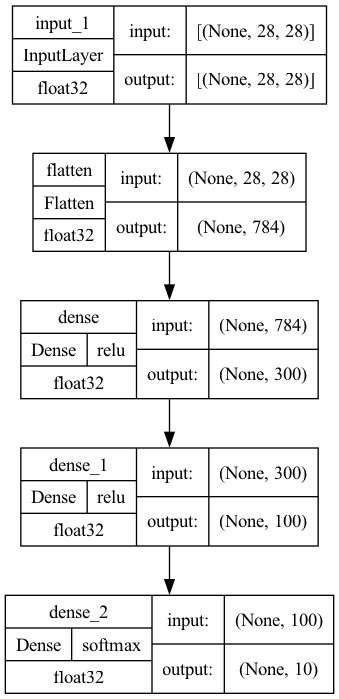

In [13]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", 
                          show_shapes=True, 
                          show_dtype=True, 
                          show_layer_names=True, 
                          show_layer_activations=True)



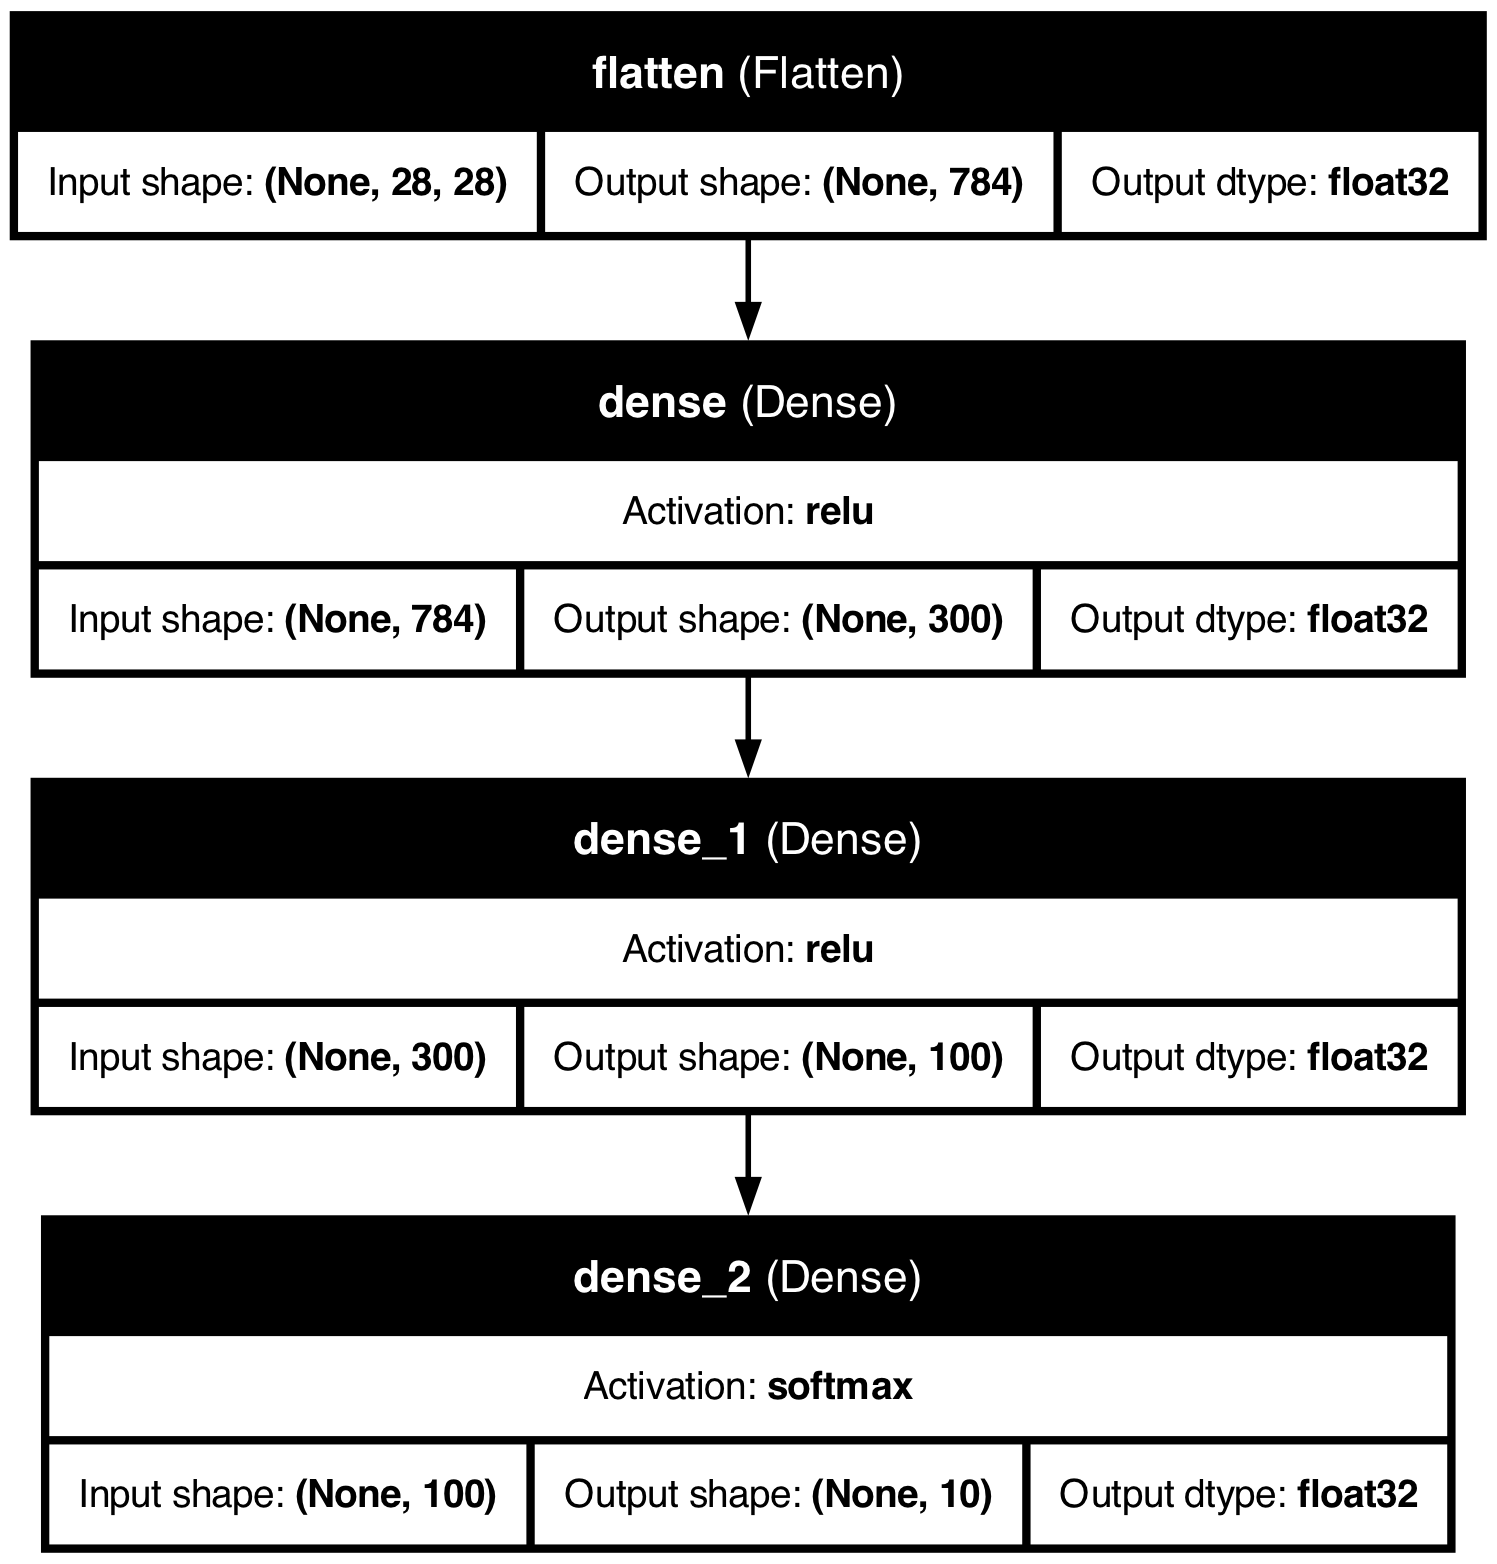

In [122]:
#Display the image
from IPython.display import Image
Image("my_fashion_mnist_model.png", width=350)

In [14]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
hidden1.name, weights

('dense',
 array([[ 0.0646655 ,  0.06864567,  0.06852403, ...,  0.0061615 ,
          0.05007621, -0.02460556],
        [-0.08407003, -0.05677245, -0.02641634, ..., -0.01138121,
         -0.010132  ,  0.03692038],
        [-0.04583975, -0.05337821,  0.03338544, ..., -0.04910797,
         -0.1116998 ,  0.04068167],
        ...,
        [ 0.04887713,  0.02439312,  0.0740125 , ..., -0.04419754,
          0.05192429, -0.05143702],
        [-0.02852097,  0.03055404,  0.02819468, ..., -0.01442732,
         -0.08020736,  0.0276502 ],
        [-0.03238258,  0.02705757,  0.02569901, ...,  0.06942883,
          0.11372596, -0.05496619]], dtype=float32))

In [15]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss="sparse_categorical_crossentropy",
            optimizer="sgd",
            # optimizer=optimizer,
            metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [16]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


2025-03-05 16:29:50.900028: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1719/1719 [==============================] - 8s 4ms/step - loss: 0.7033 - sparse_categorical_accuracy: 0.7682 - val_loss: 0.5015 - val_sparse_categorical_accuracy: 0.8270
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4834 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.4594 - val_sparse_categorical_accuracy: 0.8344
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8524
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4119 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3909 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3898 - val_sparse_categorical_accuracy: 0.8618
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3747 - sparse_categoric

In [17]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
history.params


{'verbose': 1, 'epochs': 30, 'steps': 1719}

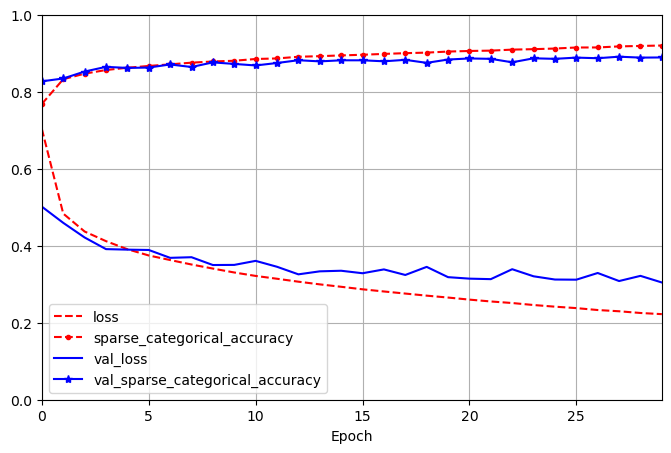

In [19]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8845


[0.32375794649124146, 0.8845000267028809]

In [21]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 1s 574ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

# Building a Regression MLP with Keras


In [23]:
# extra code – load and split the California housing dataset, like earlier
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [26]:
X_train.shape

(11610, 8)

In [27]:
tf.random.set_seed(2025)
tf.keras.backend.clear_session()

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 6ms/step - loss: 0.8779 - root_mean_squared_error: 0.9370 - val_loss: 0.4170 - val_root_mean_squared_error: 0.6458
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3707 - root_mean_squared_error: 0.6088 - val_loss: 0.7445 - val_root_mean_squared_error: 0.8628
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3503 - root_mean_squared_error: 0.5918 - val_loss: 0.4497 - val_root_mean_squared_error: 0.6706
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3382 - root_mean_squared_error: 0.5816 - val_loss: 1.7210 - val_root_mean_squared_error: 1.3119
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3320 - root_mean_squared_error: 0.5762 - val_loss: 0.6787 - val_root_mean_squared_error: 0.8238
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3138 - root_mean_squared_error: 0.5602 - val_loss: 1.0191 - val_

In [28]:
rmse_test

0.5350711345672607

In [29]:
y_pred

array([[0.5204841],
       [1.3171566],
       [4.964476 ]], dtype=float32)

---

---

# Further Reading <a id="further-reading"></a>

For Python Object Oriented Programming, check the following resources:  
</br>
- [@Kalb2022]  
</br>
- [@Slatkin2023]  
</br>
- [@Beazley2021]  


# References